# the Inplementation of Band-Limited Angular Spectrum Method (3D)

In [1]:
import numpy as np
import torch
# from torch import fft,zeros,ones
import math
import cmath
import matplotlib.pyplot as plt

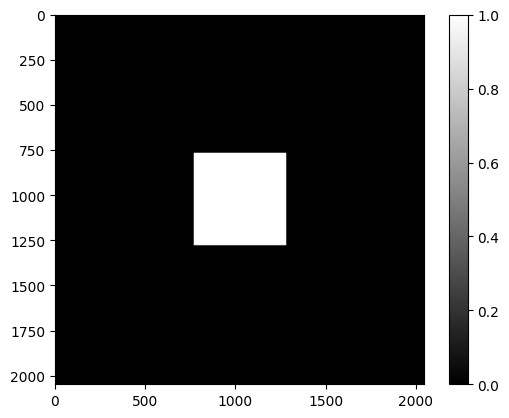

In [3]:
N = 2048
g_0 = torch.zeros((N, N))
g_0[int(N / 2) - 256 : int(N / 2) + 256, int(N / 2) - 256 : int(N / 2) + 256] = torch.ones(
    (int(512), int(512))
)
freq = torch.fft.fft2(g_0)
# freq = torch.fft.fftshift(freq)
amp = freq.abs().numpy()
amp = torch.fft.ifft2(freq)
amp = amp.abs()
amp = amp.numpy()

plt.imshow(amp, cmap='gray')
plt.colorbar()
plt.show()

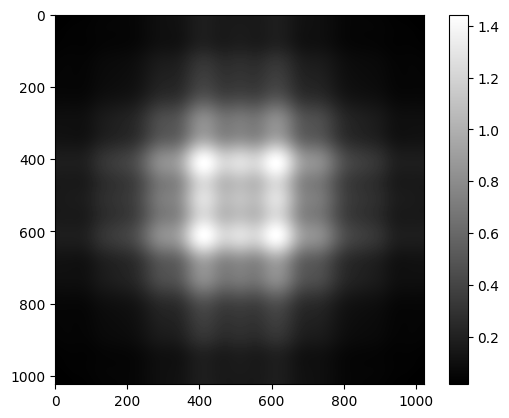

In [68]:
import numpy as np
import math


def AS_2D(wave_length=1, n_S=50, band_limit=-1):
    wave_length = wave_length  # 波长
    dx = 2 * wave_length  # 采样间隔
    N = 2048  # 采样点数
    S = 2048 * wave_length  # 采样窗口大小
    z = n_S * S  # 传播距离

    # 生成二维频率网格
    freq_x = torch.fft.fftfreq(N, dx)
    freq_y = torch.fft.fftfreq(N, dx)
    freq_x = torch.unsqueeze(freq_x, dim=1).expand(-1, len(freq_y))  # 展开为 len(y) 列
    freq_y = torch.unsqueeze(freq_y, dim=0).expand(len(freq_x), -1)  # 展开为 len(x) 行
    freq_square = freq_x**2 + freq_y**2

    freq_squre_max = torch.full((N, N), 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = torch.where(mask, w_square_0, 0)

    # 传递函数
    H_FR = torch.empty((N, N), dtype=torch.complex64)
    H_FR = torch.exp(2j * math.pi * z * torch.sqrt(w_square))

    # 生成源平面光谱
    g_0 = torch.zeros((N, N))
    g_0[
        int(N / 2) - 256 : int(N / 2) + 256, int(N / 2) - 256 : int(N / 2) + 256
    ] = torch.ones((512, 512))

    G_0 = torch.fft.fft2(g_0)

    # 目标平面光谱
    G_z = G_0 * H_FR

    if band_limit == -1:
        pass
    else:
        G_z = torch.fft.fftshift(G_z)
        # 设置频率限制
        f = band_limit
        # 应用十字形状的带宽限制
        G_z[:N // 2 + 1 - f, :] = 0
        G_z[N // 2 + f:, :] = 0
        G_z[:, :N // 2 + 1 - f] = 0
        G_z[:, N // 2 + f:] = 0

        G_z = torch.fft.ifftshift(G_z)

    # 目标平面
    g_z = torch.fft.ifft2(G_z).abs()

    return (
        H_FR.real,
        g_z[int(N / 2) - 512 : int(N / 2) + 512, int(N / 2) - 512 : int(N / 2) + 512],
    )


# # 使用函数
# H_FR_2D, g_z_2D = AS_2D(1, 100, -1)

# plt.imshow(g_z_2D, cmap="gray")
# plt.colorbar()
# plt.show()


H_FR_2D, g_z_2D = AS_2D(1, 100, 20)
plt.imshow(g_z_2D, cmap="gray")
plt.colorbar()
plt.show()

In [ ]:
# N = 2048
# g_0 = zeros((N, N))
# g_0[int(N / 2) - 256 : int(N / 2) + 256, int(N / 2) - 256 : int(N / 2) + 256] = ones(
#     (int(512), int(512))
# )
# freq = fft.fft2(g_0)
# freq = fft.fftshift(freq)
# # plt.plot(freq.abs())

In [ ]:
# the method is designed for improving the SNR in long propagation distance
def band_limited_method(source_plain, wave_length, propagation_distance):
    num_of_samplings = 1024
    sampling_interval = 2 * wave_length


In [ ]:
def AS(wave_length=1, n_S=50, band_limit=-1):
    wave_length = wave_length  # the length of the wave
    dx = 2 * wave_length  # the sampling interval
    N = 2048  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq_square = freq**2
    freq_squre_max = np.full(N, 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = np.where(mask, w_square_0, 0)

    # the transfer function
    H_FR = np.empty(N, dtype=complex)
    H_FR = np.exp(2j * math.pi * z * np.sqrt(w_square))
    # H_FR = np.exp(1j * math.pi * z * (2 / wave_length - wave_length * (freq_square)))

    # generate the source plain spectrum
    g_0 = np.zeros(N)
    g_0[int(N / 2) - 256 : int(N / 2) + 256] = np.ones(int(512))

    G_0 = np.fft.fft(g_0)

    # the dest plain spectrum
    G_z = G_0 * H_FR

    if band_limit == -1:
        pass
    else:
        # limit the bandwidth
        G_z = np.fft.fftshift(G_z)
        f = band_limit
        G_z[0 : N // 2 + 1 - f] = np.zeros(N // 2 + 1 - f)
        G_z[N // 2 + f : N] = np.zeros(N // 2 - f)
        G_z = np.fft.ifftshift(G_z)

    # the dest plain
    g_z = abs(np.fft.ifft(G_z))

    return H_FR.real, g_z[int(N / 2) - 512 : int(N / 2) + 512]